# Analysis
## Preprocessing

### Loading and checking the data

In [83]:
import os
import numpy as np
import mne
import sklearn

In [180]:
file_name = input("Name of file (format is ID0XX + pre/post)")

#reading in the vhdr file and specifying EOG channels and ECG channel
raw = mne.io.read_raw_brainvision(f"/EEGdata/{file_name}.vhdr", eog=('EOG1', 'EOG2'), misc='auto', scale=1.0, preload=False, verbose=None)

#loading the actual EEG data
raw.load_data() #for loading smaller amounts of data: raw.crop(tmin=0, tmax=3).load_data()

# dropping channels Rbelt and GSR, since we are not going to use them
raw.drop_channels(['Rbelt', 'GSR'])

# setting ecg to the ECG channel
raw.set_channel_types({'ECG':'ecg'})

#telling the mne object what montage was used
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, verbose=False);

#looking at the channels of the data
#raw.describe()


Name of file (format is ID0XX + pre/post) ID038post


Extracting parameters from /Volumes/aux/MINDLAB2019_EEG-Music-for-insomnia/EEGdata/ID038post.vhdr...
Setting channel info structure...
Reading 0 ... 2047359  =      0.000 ...  2047.359 secs...


/var/folders/6f/9pc_m95n353d8tm2r00krnb80000gn/T/ipykernel_38801/44858997.py:10: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(f"/Volumes/aux/MINDLAB2019_EEG-Music-for-insomnia/EEGdata/{file_name}.vhdr", eog=('EOG1', 'EOG2'), misc='auto', scale=1.0, preload=False, verbose=None)


### Filtering the data (notch filter, low-pass and high-pass)

Notes for this: 
Note from online "If you’re only interested in low frequencies, below the peaks of power-line noise you can simply low pass filter the data". So why am I not just doing this?
Notes form MatLab script: "De-Trending, so that we get rid of the offset and slow drift in the EEG-data", (De-trending is only available when making epochs) "Line Noise Filter using Discrete Fourier Transform", (Cannot find a Python equivalent to this) "Line Frequency (in America this would be 60)". They use 50, 100 and 150 in notch filter, but mne shows to use 50, 251, 50. The syntax in mne means filtering at from 50 to 251 with 50 hertz jumps, so filtering at 50, 100, 150, 200 and 250. This is acceptable and almost the same as in MatLab. 

Also, do I want to resample???

Effective window size : 2.048 (s)


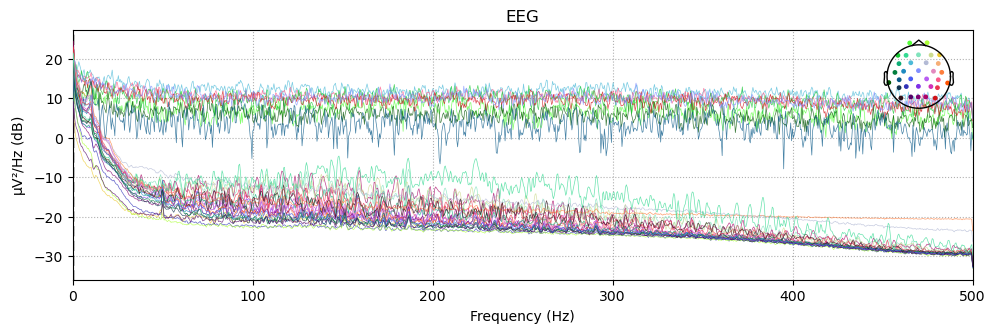

In [181]:
# just some fun plotting to see if any of the higher frequency noise sources are present (preparation for notchfiltering)

picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, ecg=False,
                       stim=False, exclude='bads')

# Let's first check out all channel types
raw.plot_psd(area_mode='range', tmax=None, picks=picks, average=False);

In [182]:
# besides the frequencies in the start, the rest is just default settings made explicit
# since I am low-pass filtering at 40 hz a later point, notch filter does not have any effect???
raw.notch_filter(np.arange(50, 251, 50), picks=picks, filter_length='auto', phase='zero')

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)



<RawBrainVision | ID038post.eeg, 35 x 2047360 (2047.4 s), ~546.8 MB, data loaded>

Effective window size : 2.048 (s)


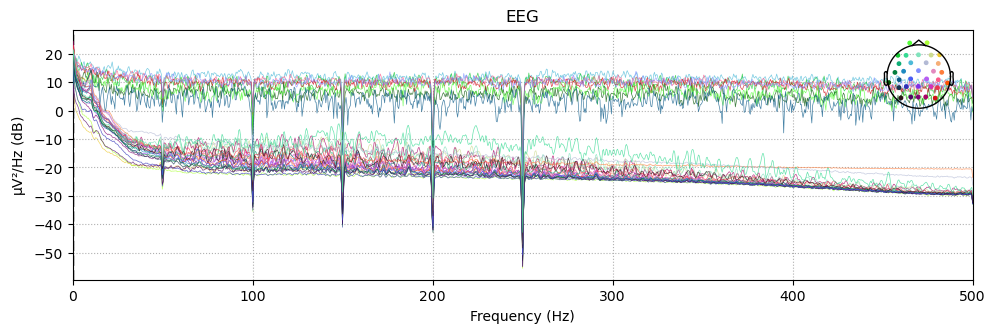

In [183]:
# just a plot to show that it has been done properly

raw.plot_psd(area_mode='range', tmax=None, picks=picks, average=False);

In [184]:
#saving a non-filtered copy for later
raw_copy = raw.copy()

In [185]:
# looking at the data and picking the bad channels (primarilly channels going flat)
raw.plot(block = True)

# bad channels
the_bad_ones = raw.info['bads']


full_sample = input("Did the sample reach the magic number 12???")

if full_sample == '1':
    end_time = input("When did the sample reach the magic number 12??? (In seconds as integer)")
    # cropping the time so there is not above 11 bad EEG channels
    raw.crop(tmax = int(end_time))
else:
    raw.crop(tmax = 1800)

Opening raw-browser...
Using pyopengl with version 3.1.6
Closing raw-browser...
Channels marked as bad:
['PO10', 'CP6', 'CP5', 'TP9', 'Cz', 'FC1', 'F7', 'Fp1']


Did the sample reach the magic number 12??? 0


In [186]:
#high-pass filter
raw.filter(l_freq=0.1, h_freq=None)

#low-pass filter
raw.filter(l_freq=None, h_freq=40)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)



<RawBrainVision | ID038post.eeg, 35 x 1800001 (1800.0 s), ~480.7 MB, data loaded>

### Looking for artefacts

In [114]:
raw.plot(block = True)

Opening raw-browser...
Using pyopengl with version 3.1.6
Closing raw-browser...
Channels marked as bad:
['Fp1', 'F7', 'F3', 'Fz', 'FC5', 'FC1', 'C4', 'CP2', 'CP6', 'TP10', 'O2']


What to do about "artefacts" or noisy parts of the data?

Well, a solution could be to mark the areas in the sample and then remove it

- "artefacts" of sorts at following timepoints: 556, 676, 1490, 1620, 1712, 1722

### ICA
I feel like it makes more sense to do before interpulation

In [187]:
# initial filtering
raw_c_filter = raw.copy()
raw_c_filter.filter(l_freq=1, h_freq=None) # mne recommends using a high-pass filter of 1 to remove slop upward drift

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 sec)



<RawBrainVision | ID038post.eeg, 35 x 1800001 (1800.0 s), ~480.7 MB, data loaded>

In [188]:
ica = mne.preprocessing.ICA(n_components=0.95, random_state=97, max_iter=800)
ica.fit(raw_c_filter)

Fitting ICA to data using 24 channels (please be patient, this may take a while)
Selecting by explained variance: 5 components
Fitting ICA took 15.3s.


Method,fastica
Fit,20 iterations on raw data (1800001 samples)
ICA components,5
Explained variance,95.5 %
Available PCA components,24
Channel types,eeg
ICA components marked for exclusion,—


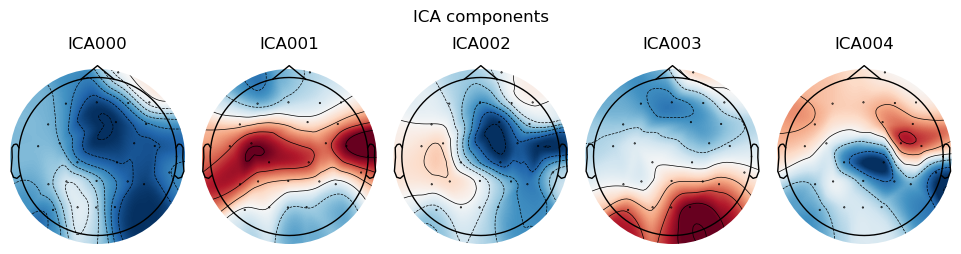

In [189]:
ica.plot_components();

# ICA002 looks to be occular movements

Using EOG channels: EOG1, EOG2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 1

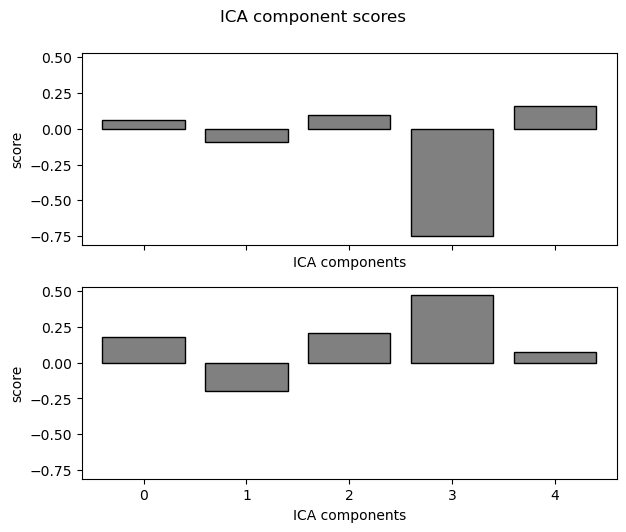

In [190]:
# barplot of ICA component "EOG match" scores
ica.exclude = []
eog_indices, eog_scores = ica.find_bads_eog(raw)
ica.plot_scores(eog_scores);

In [191]:
# plotting the time series of the ica
# in the MNE tutorial they do not use the filtered raw object
ica.plot_sources(raw_c_filter);

#using the original data incorporated the slow upward drifts which are a bit annoying to look at
# lookw like ICA002 and ICA004 is capturing eye movements



Creating RawArray with float64 data, n_channels=8, n_times=1800001
    Range : 0 ... 1800000 =      0.000 ...  1800.000 secs
Ready.
Opening ica-browser...
Using pyopengl with version 3.1.6
Closing ica-browser...


What components look like occular movements? 5,6


Applying ICA to Raw instance
    Transforming to ICA space (9 components)
    Zeroing out 2 ICA components
    Projecting back using 22 PCA components


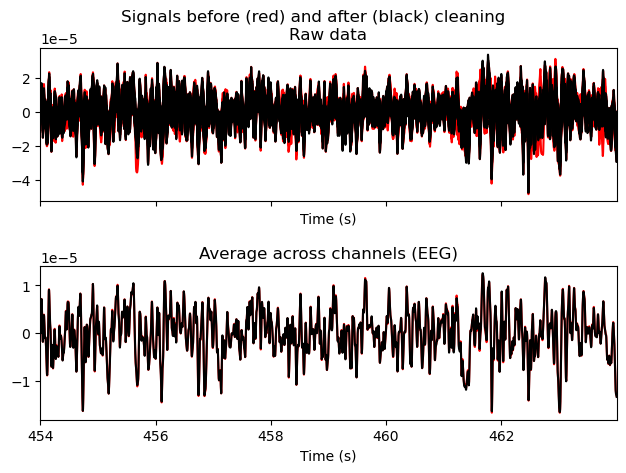

In [16]:
ica_to_exclude = input("What components look like occular movements?")
int_list = ica_to_exclude.split(",")
if int_list == ['']:
    ica_list = []
else:
    ica_list = [int(x) for x in int_list]


ica.plot_overlay(raw_c_filter, exclude=ica_list, picks='eeg', start = 454., stop = 464.);
#ica.plot_overlay(raw, exclude=[2], picks='eeg', start = 1137., stop = 1140.);

# 0: a bit hard to see anything frpm this plot. But it looks like removing the component does something, so I will remove it
# 1: correction to the thing above: stuff is prettier if we look at the filtered data. The data
# used in the mne tutorial is actually also filtered 0.1 to 40 hz from the start. It is only
# the 1.0 hz high-pass filter they are trying to get around
# 2: okay, so the original data looks a bit rubbish. Perhaps due to the slow drifts 


In [87]:
ica.plot_properties(raw, picks=ica_list)

ValueError: No appropriate channels found for the given picks ([])

In [192]:
ica_to_exclude_final = input("What components look like occular movements?")
int_list_final = ica_to_exclude_final.split(",")
ica_list_final = [int(x) for x in int_list_final]
ica.exclude = ica_list_final

What components look like occular movements? 3


In [193]:
# ica.apply() changes the Raw object in-place, so let's make a copy first:
raw_original = raw.copy()
ica.apply(raw)

raw_original.plot()
raw.plot(block = True)

Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 1 ICA component
    Projecting back using 24 PCA components
Opening raw-browser...
Using pyopengl with version 3.1.6
Opening raw-browser...
Using pyopengl with version 3.1.6
Closing raw-browser...
Channels marked as bad:
['PO10', 'CP6', 'CP5', 'TP9', 'Cz', 'FC1', 'F7', 'Fp1']
Closing raw-browser...
Channels marked as bad:
['PO10', 'CP6', 'CP5', 'TP9', 'Cz', 'FC1', 'F7', 'Fp1']


### Interpolation

In [19]:
# saving a copy
raw_copy_2 = raw.copy()

In [194]:
raw.interpolate_bads(reset_bads=True)

# something funny is happening around 977 after interpolation
# okay, so it looks like it is caused by FC2 being interpulated with variance from Cz. Nothing to do about that

Interpolating bad channels
    Automatic origin fit: head of radius 97.0 mm
Computing interpolation matrix from 24 sensor positions
Interpolating 8 sensors


<RawBrainVision | ID038post.eeg, 35 x 1800001 (1800.0 s), ~480.7 MB, data loaded>

### Re-referencing to average

In [195]:
raw.set_eeg_reference('average', projection=False, verbose=False)

<RawBrainVision | ID038post.eeg, 35 x 1800001 (1800.0 s), ~480.7 MB, data loaded>

In [196]:
raw.plot()

Opening raw-browser...
Using pyopengl with version 3.1.6


Closing raw-browser...
Channels marked as bad:
none


### Saving progress so far to file

In [197]:
raw.save(f"/Users/nielskrogsgaard/Downloads/CogNeuro_Exam/fif-files/{file_name}_raw.fif")
np.savetxt(os.path.join('/Users/nielskrogsgaard/OneDrive/CogNeuro_Exam/Bad_channel_files/', f'{file_name}.csv'), the_bad_ones, delimiter = ',', fmt='%s')

Writing /Users/nielskrogsgaard/Downloads/CogNeuro_Exam/fif-files/ID038post_raw.fif
Closing /Users/nielskrogsgaard/Downloads/CogNeuro_Exam/fif-files/ID038post_raw.fif
[done]
